# Problem Set 5

## Yanwei Pan
panyw@uchicago.edu

### Problem 1

In [132]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
from scipy.stats import lognorm
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd


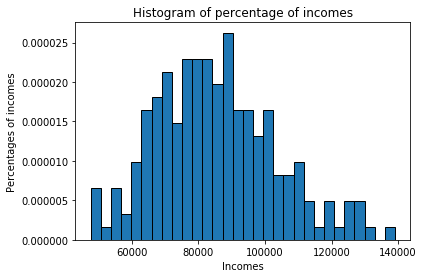

In [118]:
#a
incomes = np.loadtxt('data/incomes.txt', dtype=np.float64)
num_bins = 30
plt.hist(incomes, num_bins, edgecolor='k', density=True)
plt.xlabel('Incomes')
plt.ylabel('Percentages of incomes')
plt.title('Histogram of percentage of incomes')
plt.show()

In [42]:
#b
def data_moments1(xvals):
    data_mean = xvals.mean()
    data_std = xvals.std()
    return data_mean, data_std

def model_moments1(mu, sigma, lb, ub):
    xfx = lambda x: x * lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    (model_mean, m_m_err) = intgr.quad(xfx, lb, ub)
    x2fx = lambda x: ((x - model_mean) ** 2) * lognorm.pdf(x, s=sigma, scale=np.exp(mu)) 
    (model_var, v_m_err) = intgr.quad(x2fx, lb, ub)
    return model_mean, np.sqrt(model_var)

def err_vec(xvals, mu, lb, ub, sigma, simple):
    data_mean, data_var = data_moments1(xvals)
    data_moms = np.array([[data_mean], [data_var]])
    model_mean, model_std = model_moments1(mu, sigma, lb, ub)
    model_moms = np.array([[model_mean], [model_std]])
    if simple:
        err_vec = model_moms - data_moms
    else:
        err_vec = (model_moms - data_moms) / data_moms
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, lb, ub, W = args
    err = err_vec(xvals, mu, lb, ub, sigma, simple=False)
    crit_val = err.T @ W @ err
    return crit_val

In [34]:
mu_init = 11.0
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (incomes, 0, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), 
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('Value of GMM criterion function=', results.fun[0][0])
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
results

Value of GMM criterion function= 5.081249733090174e-16
mu_GMM1= 11.336910355090016  sig_GMM1= 0.21302707020261594


      fun: array([[5.08124973e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.27356233e-10, 4.17831083e-11])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 11
   status: 0
  success: True
        x: array([11.33691036,  0.21302707])

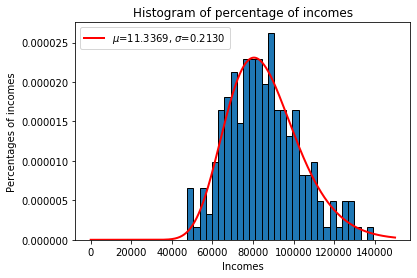

In [61]:
#plot the log normal distribution on the histogram
incomes = np.loadtxt('data/incomes.txt', dtype=np.float64)
num_bins = 30
plt.hist(incomes, num_bins, edgecolor='k', density=True)
plt.xlabel('Incomes')
plt.ylabel('Percentages of incomes')
plt.title('Histogram of percentage of incomes')

dist_pts = np.linspace(0, 150000, 300000)
mu_1 = 11.34
sig_1 = 0.21
plt.plot(dist_pts, lognorm.pdf(dist_pts, s=sig_1, scale=np.exp(mu_1)),
         linewidth=2, color='r', label='$\mu$=11.3369, $\sigma$=0.2130')
plt.legend()
plt.show()

In [50]:
data_mean, data_std = data_moments1(incomes)
model_mean, model_std = model_moments1(mu_1, sig_1, 0, 150000)
err_ve = err_vec(incomes, mu_GMM1, 0, 150000, sig_GMM1, False).reshape(2,)
print('Mean of Data=', data_mean, 'Standard deviation of Data=', data_std)
print('Mean of Model=', model_mean, 'Standard deviation of Model=', model_std)
print('The error between data moments and model moments=', err_ve)

Mean of Data= 85276.82360625811 Standard deviation of Data= 17992.542128046523
Mean of Model= 85524.58654014034 Standard deviation of Model= 17804.616293297964
The error between data moments and model moments= [ 8.83107439e-09 -2.07397468e-08]


In [91]:
#c
def get_Err_mat1(xvals, mu, sigma, lb, ub, simple):
    R = 2
    N = len(xvals)
    Err_mat = np.zeros((R, N))
    model_mean, model_std = model_moments1(mu, sigma, lb, ub)
    data_mean, data_std = data_moments1(xvals)
    if simple:
        Err_mat[0, :] = xvals - model_mean
        Err_mat[1, :] = ((data_mean - xvals) ** 2) - (model_std ** 2)
    else:
        Err_mat[0, :] = (xvals - model_mean) / model_mean
        Err_mat[1, :] = (((data_mean - xvals) ** 2) - (model_std ** 2)) / (model_std ** 2)
    return Err_mat

In [92]:
Err_mat1 = get_Err_mat1(incomes, mu_GMM1, sig_GMM1, 0, 150000, simple=False)
VCV2 = (1 / incomes.shape[0]) * (Err_mat1 @ Err_mat1.T)
print('Omega=', VCV2)
W_hat2 = lin.inv(VCV2)

Omega= [[0.04451671 0.09358616]
 [0.09358616 1.94756678]]


In [93]:
gmm_args = (incomes, 0, 150000, W_hat2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args), 
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print('Value of GMM criterion function=', results2.fun[0][0])
print('mu_GMM1=', mu_GMM2, ' sig_GMM1=', sig_GMM2)
results2

Value of GMM criterion function= 8.602294860893321e-16
mu_GMM1= 11.336910339496328  sig_GMM1= 0.21302707090429696


      fun: array([[8.60229486e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.03207508e-09,  2.29782091e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 123
      nit: 14
   status: 0
  success: True
        x: array([11.33691034,  0.21302707])

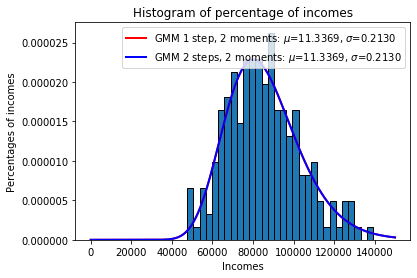

In [94]:
#plot the PDFs
plt.hist(incomes, num_bins, edgecolor='k', density=True)
plt.xlabel('Incomes')
plt.ylabel('Percentages of incomes')
plt.title('Histogram of percentage of incomes')

dist_pts = np.linspace(0, 150000, 300000)
mu_1 = mu_GMM1
sig_1 = sig_GMM1
mu_2 = mu_GMM2
sig_2 = sig_GMM2
plt.plot(dist_pts, lognorm.pdf(dist_pts, s=sig_1, scale=np.exp(mu_1)),
         linewidth=2, color='r', label=\
         'GMM 1 step, 2 moments: $\mu$=11.3369, $\sigma$=0.2130')
plt.plot(dist_pts, lognorm.pdf(dist_pts, s=sig_2, scale=np.exp(mu_2)),
         linewidth=2, color='b', label=\
         'GMM 2 steps, 2 moments: $\mu$=11.3369, $\sigma$=0.2130')
plt.legend(loc='best')
plt.show()

In [95]:
model_mean2, model_std2 = model_moments1(mu_2, sig_2, 0, 150000)
err_ve2 = err_vec(incomes, mu_GMM2, 0, 150000, sig_GMM2, False).reshape(2,)
print('Mean of Data=', data_mean, 'Standard deviation of Data=', data_std)
print('Mean of Model=', model_mean2, 'Standard deviation of Model=', model_std2)
print('The error between data moments and model moments=', err_ve2)

Mean of Data= 85276.82360625811 Standard deviation of Data= 17992.542128046523
Mean of Model= 85276.82313391558 Standard deviation of Model= 17992.54160716172
The error between data moments and model moments= [-5.53893212e-09 -2.89500395e-08]


In [107]:
#d
def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(75000 <= xvals) &(xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma, lb, ub):
    xfx = lambda x: lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, lb, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, ub)    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec3(xvals, mu, sigma, lb, ub, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    data_moms = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = \
    model_moments3(mu, sigma, lb, ub)
    model_moms = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = model_moms - data_moms
    else:
        err_vec = (model_moms - data_moms) / data_moms
    return err_vec

def criterion3(params, *args):
    mu, sigma = params
    xvals, lb, ub, W = args
    err = err_vec3(xvals, mu, sigma, lb, ub, simple=False)
    crit_val = err.T @ W @ err
    return crit_val

In [120]:
mu_init = 11.0
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat_3 = np.eye(3)
gmm_args = (incomes, 0, 500000, W_hat_3)
results3 = opt.minimize(criterion3, params_init, args=(gmm_args), 
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM3, sig_GMM3 = results3.x
print('Value of GMM criterion function=', results3.fun[0][0])
print('mu_GMM3=', mu_GMM3, ' sig_GMM3=', sig_GMM3)
results3

Value of GMM criterion function= 2.534078335677819e-15
mu_GMM3= 11.33568132742463  sig_GMM3= 0.21059845372037886


      fun: array([[2.53407834e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.46317795e-11, -4.09690363e-11])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 8
   status: 0
  success: True
        x: array([11.33568133,  0.21059845])

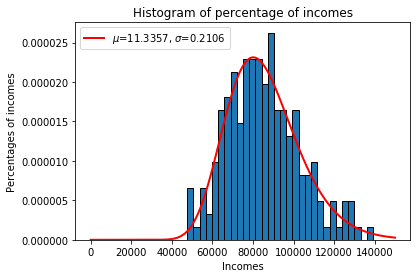

In [121]:
#plot the distribution on the histogram
plt.hist(incomes, num_bins, edgecolor='k', density=True)
plt.xlabel('Incomes')
plt.ylabel('Percentages of incomes')
plt.title('Histogram of percentage of incomes')

mu_3 = mu_GMM3
sig_3 = sig_GMM3
plt.plot(dist_pts, lognorm.pdf(dist_pts, s=sig_3, scale=np.exp(mu_3)),
         linewidth=2, color='r', label='$\mu$=11.3357, $\sigma$=0.2106')
plt.legend(loc='best')
plt.show()

In [122]:
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(incomes)
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_3, sig_3, 0, 150000)
err_ve3 = err_vec3(incomes, mu_GMM3, sig_GMM3, 0, 150000, False).reshape(3,)
print('1st moment of Data=', bpct_1_dat, '2nd moment of Data=', bpct_2_dat, '3rd moment of Data=', bpct_3_dat)
print('1st moment of Model=', bpct_1_mod, '2nd moment of Model=', bpct_2_mod, '3rd moment of Model=', bpct_3_mod)
print('The error between data moments and model moments=', err_ve3)

1st moment of Data= 0.3 2nd moment of Data= 0.5 3rd moment of Data= 0.2
1st moment of Model= 0.3000000036326453 2nd moment of Model= 0.5000000058548953 3rd moment of Model= 0.19717056561259855
The error between data moments and model moments= [ 1.21088177e-08  1.17097907e-08 -1.41471719e-02]


In [123]:
#e
def get_Err_mat3(xvals, mu, sigma, lb, ub, simple):
    R = 3
    N = len(xvals)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma, lb, ub)
    if simple:
        pts_in_grp1 = xvals < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (xvals >= 75000) & (xvals < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = (xvals >= 100000)
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod
    else:
        pts_in_grp1 = xvals < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (xvals >= 75000) & (xvals < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = (xvals >= 100000)
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    return Err_mat

In [124]:
Err_mat3 = get_Err_mat3(incomes, mu_GMM3, sig_GMM3, 0, 150000, simple=False)
VCV3 = (1 / incomes.shape[0]) * (Err_mat3 @ Err_mat3.T)
print('Omega=', VCV3)
W_hat_3_2 = lin.inv(VCV3)

Omega= [[ 2.33333328 -0.99999998 -1.01435017]
 [-0.99999998  0.99999998 -1.01435017]
 [-1.01435017 -1.01435017  4.11583113]]


In [125]:
mu_init = 11.3
sig_init = 0.21
params_init = np.array([mu_init, sig_init])
gmm_args = (incomes, 0, 500000, W_hat_3_2)
results3_2 = opt.minimize(criterion3, params_init, args=(gmm_args), 
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM3_2, sig_GMM3_2 = results3_2.x
print('Value of GMM criterion function=', results3_2.fun[0][0])
print('mu_GMM3_2=', mu_GMM3_2, ' sig_GMM3_2=', sig_GMM3_2)
results3_2

Value of GMM criterion function= 1.648710516587031e-15
mu_GMM3_2= 11.335681327723822  sig_GMM3_2= 0.21059845538978492


      fun: array([[1.64871052e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.58233306e-11, -9.38199519e-12])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 8
   status: 0
  success: True
        x: array([11.33568133,  0.21059846])

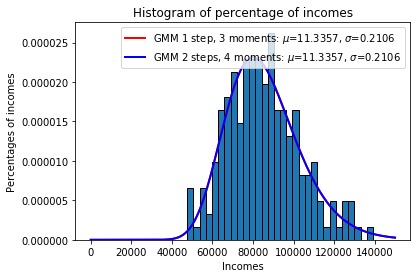

In [128]:
#plot the PDFs
plt.hist(incomes, num_bins, edgecolor='k', density=True)
plt.xlabel('Incomes')
plt.ylabel('Percentages of incomes')
plt.title('Histogram of percentage of incomes')

dist_pts = np.linspace(0, 150000, 300000)
mu3_1 = mu_GMM3
sig3_1 = sig_GMM3
mu3_2 = mu_GMM3_2
sig3_2 = sig_GMM3_2
plt.plot(dist_pts, lognorm.pdf(dist_pts, s=sig3_1, scale=np.exp(mu3_1)),
         linewidth=2, color='r', label=\
         'GMM 1 step, 3 moments: $\mu$=11.3357, $\sigma$=0.2106')
plt.plot(dist_pts, lognorm.pdf(dist_pts, s=sig3_2, scale=np.exp(mu3_2)),
         linewidth=2, color='b', label=\
         'GMM 2 steps, 4 moments: $\mu$=11.3357, $\sigma$=0.2106')
plt.legend(loc='best')
plt.show()

In [130]:
bpct_1_mod2, bpct_2_mod2, bpct_3_mod2 = model_moments3(mu3_2, sig3_2, 0, 500000)
err_ve3_2 = err_vec3(incomes, mu_GMM3_2, sig_GMM3_2, 0, 500000, False).reshape(3,)
print('1st moment of Data=', bpct_1_dat, '2nd moment of Data=', bpct_2_dat, '3rd moment of Data=', bpct_3_dat)
print('1st moment of Model=', bpct_1_mod2, '2nd moment of Model=', bpct_2_mod2, '3rd moment of Model=', bpct_3_mod2)
print('The error between data moments and model moments=', err_ve3_2)

1st moment of Data= 0.3 2nd moment of Data= 0.5 3rd moment of Data= 0.2
1st moment of Model= 0.3000000045840119 2nd moment of Model= 0.5000000026380281 3rd moment of Model= 0.19999999277796005
The error between data moments and model moments= [ 1.52800396e-08  5.27605626e-09 -3.61101998e-08]


In [133]:
#f
mu = [mu_1, mu_2, mu3_1, mu3_2]
sig = [sig_1, sig_2, sig3_1, sig3_2]
v = [results.fun[0][0], results2.fun[0][0], results3.fun[0][0], results3_2.fun[0][0]]
df = pd.DataFrame({'mu': mu, 'sigma': sig, 'Value of GMM criterion function': v})
df

,mu,sigma,Value of GMM criterion function
0,11.336910,0.213027,5.081250e-16
1,11.336910,0.213027,8.602295e-16
2,11.335681,0.210598,2.534078e-15
3,11.335681,0.210598,1.648711e-15


As we can see in the chart above, the first model that uses the average income and standard deviation of income as two moments, one step, generates the minimal value of criterion function. Thus, the first model fits the data best.

### Problem 2

In [134]:
#a
sicks = pd.read_csv('data/sick.txt', dtype=np.float64)
sicks

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90
...,...,...,...,...
195,0.53,30.56,0.74,41.76
196,0.86,33.97,1.40,39.10
197,1.39,44.00,2.45,40.95
198,0.72,22.30,1.03,23.14


In [135]:
def err_vec_lin(df, b0, b1, b2, b3):
    model_moms = b0 + b1 * df['age'] + b2 * df['children'] + b3 * df['avgtemp_winter']
    err_vec = df['sick'] - model_moms
    return err_vec

def criterion_lin(params, *args):
    b0, b1, b2, b3 = params
    df, W = args
    err = err_vec_lin(df, b0, b1, b2, b3)
    crit_val = err.T @ W @ err
    return crit_val

In [139]:
params_init_lin = np.array([0, 0, 1, 1])
W_hat_lin = np.eye(200)
gmm_args = (sicks, W_hat_lin)
results_lin = opt.minimize(criterion_lin, params_init_lin, args=(gmm_args), 
                       tol=1e-14, method='L-BFGS-B')
b0, b1, b2, b3 = results_lin.x
print('Value of GMM criterion function=', results_lin.fun)
print('b0=', b0, ' b1=', b1, 'b2=', b2, 'b3=', b3)
results_lin

Value of GMM criterion function= 0.0018212897221037668
b0= 0.25164219487317596  b1= 0.012933401131902026 b2= 0.40050169351283427 b3= -0.009991609361712174


      fun: 0.0018212897221037668
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.89050337e-05, 3.13266843e-03, 7.48591076e-05, 4.40165339e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 360
      nit: 38
   status: 0
  success: True
        x: array([ 0.25164219,  0.0129334 ,  0.40050169, -0.00999161])